# Project 3 Hassan Alam
## Goal:
Deveop framework for Multi-Variate Time Series Forecast

## Sections

Section 1: Import All Libraries
Section 2: Import Alpaca Data
Section 3: LSTM
Section 4: NewsAPI
Section 5: Get Tones from IBM


## Notes - to delete
1. V 1.0 All cells working. 

##  <span style="color:red">Section 1: Import All Libraries

In [48]:
import alpaca_trade_api as tradeapi
import json
import numpy as np
import os
import pandas as pd
import requests

from datetime import datetime, date, timedelta
# from datetime import date
from dotenv import load_dotenv
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from keras.models import Sequential
from keras.layers import Dense, LSTM
# from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from newsapi import NewsApiClient
from numpy import concatenate
# from numpy import concatenate
from pandas import read_csv, DataFrame, concat
# from pandas import DataFrame
# from pandas import concat
from pandas.io.json import json_normalize
# import pandas as pd
from pandas import read_csv
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


%matplotlib inline
load_dotenv('test1.env')

True

##  <span style="color:red">Section 2: Import Alpaca Data

### Section 2.1
Currently reads file. Need to put in Alpaca

In [3]:
# csv_path = Path("../Resources/trading_signals.csv")
csv_path = Path ("./sp500_close_2020-2021.csv", infer_datetime_format = True,  parse_dates=True, index_col='time')
SP500_close = read_csv(csv_path)
# raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')
SP500_close['time'] = pd.to_datetime (SP500_close['time'])
SP500_close.set_index('time', inplace = True)
# SP500_close = SP500_close.iloc[:, 1:]
SP500_close.head()


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02 05:00:00+00:00,85.95,29.09,159.40,300.58,89.57,85.09,168.81,86.94,210.15,334.48,...,62.38,101.69,70.900,56.94,79.87,102.18,149.20,259.14,52.44,134.150
2020-01-03 05:00:00+00:00,84.53,27.65,159.48,297.38,88.67,83.99,166.75,85.84,209.76,331.71,...,62.68,99.31,70.320,56.30,80.29,101.84,148.75,256.10,51.70,134.110
2020-01-06 05:00:00+00:00,84.78,27.32,156.82,299.78,89.40,85.25,179.07,86.33,208.43,333.71,...,62.59,97.23,70.870,56.61,79.81,101.79,147.95,258.01,51.07,133.100
2020-01-07 05:00:00+00:00,85.09,27.22,154.95,298.27,88.87,84.63,180.36,85.87,203.92,333.51,...,62.46,99.46,70.280,56.91,79.50,101.97,147.83,256.47,50.74,133.600
2020-01-08 05:00:00+00:00,85.91,27.84,153.15,303.15,89.52,85.45,178.72,86.21,204.37,337.92,...,62.42,99.19,69.235,57.51,79.78,102.14,149.59,247.63,51.26,133.325


In [4]:
df_pct_change = SP500_close.pct_change().dropna(how='all')
# SP500_close.pct_change()
df_pct_change.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
time,,,,,,,,,,,,,,,,,,,,,
2020-01-03 05:00:00+00:00,-0.016521,-0.049502,0.000502,-0.010646,-0.010048,-0.012927,-0.012203,-0.012652,-0.001856,-0.008282,...,0.004809,-0.023404,-0.008181,-0.011240,0.005259,-0.003327,-0.003016,-0.011731,-0.014111,-0.000298
2020-01-06 05:00:00+00:00,0.002958,-0.011935,-0.016679,0.008070,0.008233,0.015002,0.073883,0.005708,-0.006341,0.006029,...,-0.001436,-0.020945,0.007821,0.005506,-0.005978,-0.000491,-0.005378,0.007458,-0.012186,-0.007531
2020-01-07 05:00:00+00:00,0.003657,-0.003660,-0.011924,-0.005037,-0.005928,-0.007273,0.007204,-0.005328,-0.021638,-0.000599,...,-0.002077,0.022935,-0.008325,0.005299,-0.003884,0.001768,-0.000811,-0.005969,-0.006462,0.003757
2020-01-08 05:00:00+00:00,0.009637,0.022777,-0.011617,0.016361,0.007314,0.009689,-0.009093,0.003959,0.002207,0.013223,...,-0.000640,-0.002715,-0.014869,0.010543,0.003522,0.001667,0.011906,-0.034468,0.010248,-0.002058
2020-01-09 05:00:00+00:00,0.015714,0.003951,-0.001763,0.021639,0.007708,0.014160,0.028424,0.002552,0.009003,0.007487,...,0.001922,0.023490,0.007727,0.000869,0.004387,0.008028,-0.006752,-0.004563,0.006828,0.013163


In [5]:
SP500_close.shift().head(5)
df_change = SP500_close/SP500_close.shift()
df_log_change = np.log(SP500_close/SP500_close.shift())


In [7]:
num_of_cols = 5
raw_df = df_log_change.iloc[:, : num_of_cols]
raw_df.head()

,A,AAL,AAP,AAPL,ABBV
time,,,,,
2020-01-02 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-01-03 05:00:00+00:00,-0.016659,-0.050769,0.000502,-0.010703,-0.010099
2020-01-06 05:00:00+00:00,0.002953,-0.012007,-0.016820,0.008038,0.008199
2020-01-07 05:00:00+00:00,0.003650,-0.003667,-0.011996,-0.005050,-0.005946
2020-01-08 05:00:00+00:00,0.009591,0.022522,-0.011685,0.016229,0.007287


In [35]:
date_index_df = raw_df.copy()
# test.index = pd.to_datetime(test.index, format = '%Y-%m-%d')
date_index_df.index = date_index_df.index.strftime('%Y-%m-%d')
date_index_df.head(2)

,A,AAL,AAP,AAPL,ABBV
2020-01-02,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.016659,-0.050769,0.000502,-0.010703,-0.010099


## <span style="color:red">Section 3: LSTM</span>.

### 3.1 Notes
1. it takes raw df, change to a fucntion
2. imports on top may not be necessary or should be pulled into top
3. Make into a function

value shape: (84, 5)
reframe shape: (82, 6)


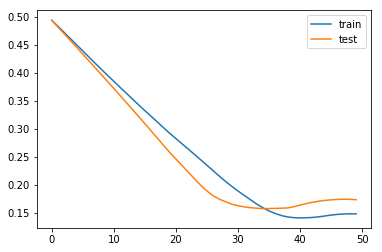

inv_y shape: (25, 5)
Test RMSE: 0.040


In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = raw_df
values = dataset.values
# integer encode direction

# take this out
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features

# debug
print (f'value shape: {values.shape}') #debug

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

# redo this secttion
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
## num_col_to_drop = lstm_input.shape[1] - scaled_data.shape[1]
#### drop the columns at the end
## lstm_input = lstm_input.iloc[:, : - num_col_to_drop]

#above 
#calculate the number of columns to drop
num_col_to_drop =  reframed.shape[1] - dataset.shape[1] -1
# drop the clast columns
reframed = reframed.iloc[:, : -num_col_to_drop]
print (f'reframe shape: {reframed.shape}')
#

# print(reframed.head())
 
# split into train and test sets
values = reframed.values

# redo this section
# n_train_hours = 365 * 24
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]

# redone here
# set test_fraction (set it to 0.7)
test_fract = 0.7
split = int(test_fract * len(values))
train = values[:split, :]
test = values [split:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
# change verbose to zo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

# debug
print (f'inv_y shape: {inv_yhat.shape}')

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

## <span style="color:red">Section 4: NewsAPI

### 4.1. 
1. parameterize topic for query
2. current system only does last 30 days.. once code is done download last 3 years to get test data on all stocks
3. Need to synchronize with stock time data

In [10]:
from newsapi import NewsApiClient

In [12]:
# Create a newsapi client
api_key = os.getenv("news_api")
newsapi = NewsApiClient(api_key=api_key)

In [13]:
# Fetch top news articles about oil
oil_headlines = newsapi.get_top_headlines(q="oil")
oil_headlines

{'status': 'ok',
 'totalResults': 1,
 'articles': [{'source': {'id': None, 'name': 'Hindustan Times'},
   'author': 'Shishir Gupta',
   'title': '14 Keralites with ISKP, blast outside Turkmenistan mission in Kabul foiled - Hindustan Times',
   'description': 'Credible reports from Kabul indicate the Taliban detained two Pakistani nationals with an explosive device outside the Turkmenistan embassy after the Kabul airport attack on August 26. | World News',
   'url': 'https://www.hindustantimes.com/world-news/14-keralites-with-iskp-blast-outside-turkmenistan-mission-in-kabul-foiled-101630120774066.html',
   'urlToImage': 'https://images.hindustantimes.com/img/2021/08/28/1600x900/Keralites_ISKP_Turkmenistan_Kabul__1630121175382_1630121187947.jpg',
   'publishedAt': '2021-08-28T03:28:31Z',
   'content': 'At least 14 Kerala residents are part of the Islamic State of Khorasan Province (ISKP) terror group after being freed by the Taliban from Bagram jail even as there are unconfirmed reports 

In [14]:
# Transform the response dictionary to a DataFrame
oil_df = pd.DataFrame.from_dict(oil_headlines["articles"])

oil_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Hindustan Times'}",Shishir Gupta,"14 Keralites with ISKP, blast outside Turkmeni...",Credible reports from Kabul indicate the Talib...,https://www.hindustantimes.com/world-news/14-k...,https://images.hindustantimes.com/img/2021/08/...,2021-08-28T03:28:31Z,At least 14 Kerala residents are part of the I...


In [ ]:
# delete
from datetime import datetime, timedelta   

In [29]:
# can only get 30 days of data without paid accoutn
# set start date to 30 days ago
from_date = (date.today()- timedelta(30)).strftime("%Y-%m-%d")
#set endate as today
to_date = date.today().strftime("%Y-%m-%d")
# this is current topic. parameterize this
query = "google"
all_articles = newsapi.get_everything(q=query,language='en',
        sort_by='relevancy',from_param=from_date,to=to_date)

In [27]:
# delete
# from datetime import datetime, timedelta   
# print (date.today())
# date.today().strftime("%Y-%m-%d")
# (date.today()- timedelta(30)).strftime("%Y-%m-%d")

2021-08-29


'2021-07-30'

In [ ]:
# delete
# art_df = pd.DataFrame.from_dict(all_articles['articles'])
art_df.head(2)
art_df['date'] = art_df['publishedAt'].apply (lambda x: x[:10])
art_df['date']

In [30]:
def sort_news (in_news):
    '''
    loop through artiles in news api and sort by date.
    create data frame 
    one dataframe with full content
    second with text and date only
    '''
    #convert articles to dataframe
    art_df = pd.DataFrame.from_dict(all_articles['articles'])
    #change to a date string
#     df['age']=df.apply(lambda x: x['age']+3,axis=1)
    # create a column text that concats title descripiton and content
    art_df ['text'] = art_df['title'] + " " + art_df['description'] + " " + art_df['content']
    art_df['date'] = art_df['publishedAt'].apply (lambda x: x[:10])
    #sort by date
    art_df.sort_values (by=['date'], inplace = True)
    #concat all text by date
    text_df = art_df.groupby('date')['text'].apply (lambda x: ','.join (x)).reset_index()
    return art_df, text_df
    
    

In [31]:
art_df, text_df = sort_news(all_articles)
# text_df.head(5)

,date,text
0,2021-07-30,Pittsburgh Google contractors ratify deal with...
1,2021-07-31,Apple pulls anti-vax social app over misinform...
2,2021-08-03,Google Maps for iOS gets dark mode and new loc...
3,2021-08-05,Everything You Need to Know About Google Drive...
4,2021-08-07,Google reportedly planning a new Silicon Valle...


In [33]:
test_text = text_df.copy()
test_text.set_index('date', drop = True, inplace = True)
# test_text.head()

In [146]:
# delete
# test_text = text_df.copy()
# test_text.set_index('date', drop = True, inplace = True)
# test_text.head()

,text
date,
2021-07-27,Google TV mobile app redesign adds new service...
2021-07-28,Google will require coronavirus vaccines for r...
2021-07-29,Google Is Booting 'Sugar Daddy' Apps From the ...
2021-07-30,Pittsburgh Google contractors ratify deal with...
2021-07-31,Apple pulls anti-vax social app over misinform...


#### 4.2.2 combine data with news


In [36]:
news_price = pd.concat([date_index_df, test_text], axis = 1, join = "outer")
news_price.head(5)

C:\Users\Hassan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,A,AAL,AAP,AAPL,ABBV,text
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.016659,-0.050769,0.000502,-0.010703,-0.010099,NaN
2020-01-06,0.002953,-0.012007,-0.016820,0.008038,0.008199,NaN
2020-01-07,0.003650,-0.003667,-0.011996,-0.005050,-0.005946,NaN
2020-01-08,0.009591,0.022522,-0.011685,0.016229,0.007287,NaN


## Section 5: Get Tones from IBM

In [37]:
# Get the Tone Analyzer API Key and URL
tone_api = os.getenv("TONE_ANALYZER_APIKEY")
tone_url = os.getenv("TONE_ANALYZER_URL")

In [38]:
def init_ibm():
    '''
    code to initialize IBM netork
    '''
    #load environment
    load_dotenv('ibm-credentials.env')
    # Initialize Tone Analyser Client

    # Create authentication object
    authenticator = IAMAuthenticator(tone_api)

    # Create tone_analyzer instance
    tone_analyzer = ToneAnalyzerV3(
        version="2017-09-21",
        authenticator=authenticator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
    )

    # Set the service endpoint
    tone_analyzer.set_service_url(tone_url)
    return tone_analyzer

In [39]:
def create_tone_series(in_text):
    '''
    Takes a text and generates a series of tones based on tonlist
    need to make sure IBM network is alived
    in_text = text to be analzye
    in_tn = tone analyzer
    
    '''
    #set error variabes
    sent_tone = False
    doc_tone = False
    
    #analzye the doe
    tone_analysis = tone_analyzer.tone(
        {"text": in_text},
        content_type="application/json",
        content_language="en",
        accept_language="en",
    ).get_result()
    
    # debug
    # debug print(json.dumps(tone_analysis, indent=2))
    
    #create sentence tone df
    # check if there is a sensettone, then put 
    try:
        sentences_tone_df = json_normalize(
            data=tone_analysis["sentences_tone"],
            record_path=["tones"],
            meta=["sentence_id", "text"],
            )
        sent_tone = True
    except:
        set_tone = False
    
    #change it to a dataframe
    try:
        doc_tone_df = json_normalize(data=tone_analysis["document_tone"], record_path=["tones"])
        doc_tone = True
    except:
        doc_tone = False
        
    
    #creae summary fo all tones
    # debug print (f'sent_done: {sent_tone}\n')
    # debug print (f'doc_tone: {doc_tone}\n')
    if sent_tone:
        tsp_df = sentences_tone_df.groupby('tone_id').sum().transpose()
    elif doc_tone:
        tsp_df = doc_tone_df.groupby('tone_id').sum().transpose()
    else:
        return 'error'

    #define list of tones
    tone_list = ['excited', 'frustrated','impolite', 'polite', 'sad', 'satisfied', 'sympathetic', 
             'anger', 'disgust', 'fear', 'joy', 'sadness',
            'analytical', 'confident', 'tentative',
            'openness_big5', 'conscientiousness_big5', 'extraversion_big5', 'agreeableness_big5',  'emotional_range_big5']
    
    #create tone df with all zeros
    zero_df = pd.DataFrame(0, index=np.arange(1), columns=tone_list)
    #replace falues from tone_df
    zero_df [tsp_df.columns] = tsp_df[tsp_df.columns].values
       
    # debug print (f'zero_df[0]: {zero_df.iloc[0]}\n')  

    return zero_df.iloc[0]

In [41]:
# Initialize Tone Analyser Client

# Create authentication object
authenticator = IAMAuthenticator(tone_api)

# Create tone_analyzer instance
tone_analyzer = ToneAnalyzerV3(
    version="2017-09-21",
    authenticator=authenticator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
)

# Set the service endpoint
tone_analyzer.set_service_url(tone_url)

In [42]:
# Define text to analyze
# test 
text = """
Team, I know that times are tough! 
Product sales have been disappointing for the past three quarters. 
We have a competitive product, but we need to do a better job of selling it!
"""
# text = """Team, I know that times are tough!"""

# Analyze the text's tone with the 'tone()' method.
tone_analysis = tone_analyzer.tone(
    {"text": text},
    content_type="application/json",
    content_language="en",
    accept_language="en",
).get_result()

# Display tone analysis results
print(json.dumps(tone_analysis, indent=2))

{
  "document_tone": {
    "tones": [
      {
        "score": 0.6165,
        "tone_id": "sadness",
        "tone_name": "Sadness"
      },
      {
        "score": 0.829888,
        "tone_id": "analytical",
        "tone_name": "Analytical"
      }
    ]
  },
  "sentences_tone": [
    {
      "sentence_id": 0,
      "text": "Team, I know that times are tough!",
      "tones": [
        {
          "score": 0.801827,
          "tone_id": "analytical",
          "tone_name": "Analytical"
        }
      ]
    },
    {
      "sentence_id": 1,
      "text": "Product sales have been disappointing for the past three quarters.",
      "tones": [
        {
          "score": 0.771241,
          "tone_id": "sadness",
          "tone_name": "Sadness"
        },
        {
          "score": 0.687768,
          "tone_id": "analytical",
          "tone_name": "Analytical"
        }
      ]
    },
    {
      "sentence_id": 2,
      "text": "We have a competitive product, but we need to do a bette

In [43]:
# Document Tones
doc_tone_df = json_normalize(data=tone_analysis["document_tone"], record_path=["tones"])
doc_tone_df

,score,tone_id,tone_name
0,0.616500,sadness,Sadness
1,0.829888,analytical,Analytical


In [44]:
# Sentences Tones
sentences_tone_df = json_normalize(
    data=tone_analysis["sentences_tone"],
    record_path=["tones"],
    meta=["sentence_id", "text"],
)
sentences_tone_df

,score,tone_id,tone_name,sentence_id,text
0,0.801827,analytical,Analytical,0,"Team, I know that times are tough!"
1,0.771241,sadness,Sadness,1,Product sales have been disappointing for the ...
2,0.687768,analytical,Analytical,1,Product sales have been disappointing for the ...
3,0.506763,analytical,Analytical,2,"We have a competitive product, but we need to ..."


In [46]:
test_df = sentences_tone_df.copy()

tone_list = ['excited', 'frustrated','impolite', 'polite', 'sad', 'satisfied', 'sympathetic', 
             'anger', 'disgust', 'fear', 'joy', 'sadness',
            'analytical', 'confident', 'tentative',
            'openness_big5', 'conscientiousness_big5', 'extraversion_big5', 'agreeableness_big5',  'emotional_range_big5']
tone_analyzer = init_ibm()

In [47]:
test_df = sentences_tone_df.copy()
# test_df[tone_list] = test_df['text'].apply(create_tone_series)
# appiled_df = df.apply(lambda row: fn(row.text), axis='columns', result_type='expand') 
test_df[tone_list] = test_df['text'].apply(lambda x: create_tone_series(x))
# # df.merge(df.textcol.apply(lambda s: pd.Series({'feature1':s+1, 'feature2':s-1})), 
#     left_index=True, right_index=True)
# test_df.merge(test_df.textcol.apply(lambda s:create_tone_series(x)), left_index=True, right_index=True)
test_df.head()

,score,tone_id,tone_name,sentence_id,text,excited,frustrated,impolite,polite,sad,...,joy,sadness,analytical,confident,tentative,openness_big5,conscientiousness_big5,extraversion_big5,agreeableness_big5,emotional_range_big5
0,0.801827,analytical,Analytical,0,"Team, I know that times are tough!",0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.801827,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.771241,sadness,Sadness,1,Product sales have been disappointing for the ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.771241,0.687768,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.687768,analytical,Analytical,1,Product sales have been disappointing for the ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.771241,0.687768,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.506763,analytical,Analytical,2,"We have a competitive product, but we need to ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.506763,0.0,0.0,0.0,0.0,0.0,0.0,0.0
